# Tutorial 2: ATAC-RNA-Seq Mouse Brain RNA and ATAC Multi-Omics Data

We applied COSMOS to analyze a spatially resolved multi-omics dataset based on real-world experiments instead of simulated data. This experimental dataset contains P22 mouse brain coronal sections with a joint profiling of spatial chromatin accessibility (ATAC) and spatial transcriptome (RNA). The annotation was manually generated by aligning the sample with the P56 mouse brain coronal section from Allen Mouse Brain Atlas.

The raw data can be downloaded from: 
https://brain-spatial-omics.cells.ucsc.edu

The processed data is available at: https://zenodo.org/records/13932144

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import sklearn.metrics
import seaborn as sns
# from COSMOS.cosmos import Cosmos
from COSMOS.cosmos_transformer_pe_version import Cosmos
from COSMOS.pyWNN import pyWNN 
import h5py
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

##  Preparation of data

### Importing the data

In [11]:
data_mat = h5py.File('./ATAC_RNA_Seq_MouseBrain_RNA_ATAC.h5', 'r')
df_data_RNA = np.array(data_mat['X_RNA']).astype('float64')     # gene count matrix
df_data_ATAC= np.array(data_mat['X_ATAC']).astype('float64')  # protein count matrix
loc = np.array(data_mat['Pos']).astype('float64') 
LayerName = list(data_mat['LayerName'])
LayerName = [item.decode("utf-8") for item in LayerName]

adata1 = sc.AnnData(df_data_RNA, dtype="float64")
adata1.obsm['spatial'] = np.array(loc)
adata1.obs['LayerName'] = LayerName
adata1.obs['x_pos'] = np.array(loc)[:,0]
adata1.obs['y_pos'] = np.array(loc)[:,1]

adata2 = sc.AnnData(df_data_ATAC, dtype="float64")
adata2.obsm['spatial'] = np.array(loc)
adata2.obs['LayerName'] = LayerName
adata2.obs['x_pos'] = np.array(loc)[:,0]
adata2.obs['y_pos'] = np.array(loc)[:,1]

### Visualizing spatial positions with annotation

(np.float64(-4.95),
 np.float64(103.95),
 np.float64(-2.8500000000000005),
 np.float64(103.85))

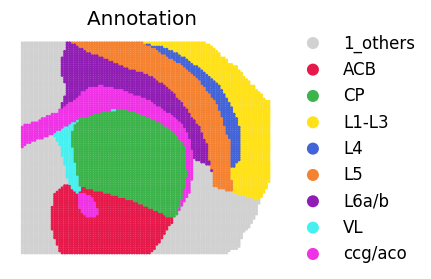

In [12]:
adata_new = adata1.copy()
adata_new.obs["LayerName"]=adata_new.obs["LayerName"].astype('category')


matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(3.5,3))
sz = 20
plot_color=['#D1D1D1','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Annotation ' 
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')

## Applying COSMOS to integrate RNA and ATAC omics

In [ ]:
## COSMOS training 
cosmos_comb = Cosmos(adata1=adata1,adata2=adata2)
cosmos_comb.preprocessing_data(n_neighbors = 10)
cosmos_comb.train(spatial_regularization_strength=0.01, z_dim=50, 
         lr=1e-3, wnn_epoch = 100, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
         random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)
weights = cosmos_comb.weights
df_embedding = pd.DataFrame(cosmos_comb.embedding)

Epoch 1/1000, Loss: 1.4093431234359741
Epoch 11/1000, Loss: 1.1189649105072021
Epoch 21/1000, Loss: 0.76047283411026
Epoch 31/1000, Loss: 0.41211050748825073
Epoch 41/1000, Loss: 0.1727161705493927
Epoch 51/1000, Loss: 0.06818228214979172
Epoch 61/1000, Loss: 0.03348870202898979
Epoch 71/1000, Loss: 0.02144620381295681
Epoch 81/1000, Loss: 0.016575589776039124
Epoch 91/1000, Loss: 0.013172032311558723
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 9215 0.01 seconds elapsed
2000 out of 9215 10.56 seconds elapsed
4000 out of 9215 19.83 seconds elapsed
6000 out of 9215 29.62 seconds elapsed
8000 out of 9215 39.60 seconds elapsed
Selecting top K neighbors
Epoch 101/1000, Loss: 0.025333251804113388
Epoch 111/1000, Loss: 0.019249092787504196
Epoch 121/1000, Loss: 0.014394760131835938
Epoch 131/1000, Loss: 0.013662971556186676
Epoch 141/1000, Loss: 0.0107

### Clustering of COSMOS integration

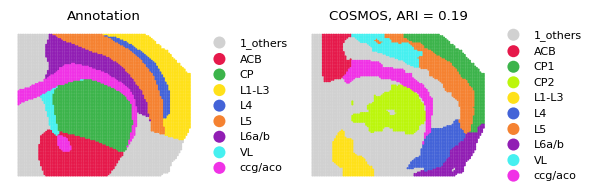

In [14]:
adata_new = adata1.copy()
embedding_adata = sc.AnnData(df_embedding)
sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')

# Manualy setting resolution for clustering
res = 1.0
sc.tl.leiden(embedding_adata, resolution=res)
adata_new.obs['Cluster_cosmos'] = list(embedding_adata.obs["leiden"].cat.codes)
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')

# Relabeling clusters with layer names
digit_labels = list(adata_new.obs['Cluster_cosmos'])
for i in range(len(digit_labels)):
    if digit_labels[i] not in [0,1,2,4,5,6,7,8,11]:
        digit_labels[i] = 100
adata_new.obs['Cluster_cosmos'] = digit_labels
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')
adata_new.obs['Cluster_cosmos']=adata_new.obs['Cluster_cosmos'].cat.rename_categories({0: 'CP2',
                                                   1: 'L5',
                                                   2: 'CP1',
                                                   4: 'L4',
                                                   5: 'ccg/aco',
                                                   6: 'ACB',
                                                   7: 'L1-L3',
                                                    8: 'L6a/b',
                                                   11: 'VL',
                                                    100: '1_others'
                                                         })

ordered_cluster = np.unique(list(adata_new.obs['Cluster_cosmos']))
adata_new.obs['Cluster_cosmos'] = adata_new.obs['Cluster_cosmos'].cat.reorder_categories(ordered_cluster, ordered=True)

# Calculating ARI
opt_cluster_cosmos = list(adata_new.obs['Cluster_cosmos'])
opt_ari_cosmos = sklearn.metrics.adjusted_rand_score(LayerName, opt_cluster_cosmos)
opt_ari_cosmos = round(opt_ari_cosmos, 2)

# Ploting figures
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 2, figsize=(6,2))
sz = 10
plot_color=['#D1D1D1','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Annotation' 
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[0])
ax.axis('off')

plot_color_1=['#D1D1D1','#e6194b', '#3cb44b', '#bcf60c','#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
             '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color_1[:num_celltype])
titles = 'COSMOS, ARI = ' + str(opt_ari_cosmos)
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color_1,show=False,size=sz,ax = axes[1])
ax.axis('off')
plt.tight_layout()


### UMAP visualization of COSMOS integration

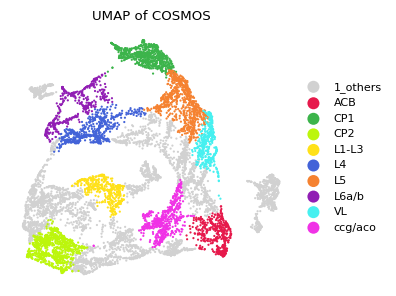

In [15]:
# UMAP visualization
umap_2d = UMAP(n_components=2, init='random', random_state=random_seed, min_dist = 0.3,n_neighbors=30)
umap_pos = umap_2d.fit_transform(df_embedding)
adata_new.obs['cosmos_umap_pos_x'] = umap_pos[:,0]
adata_new.obs['cosmos_umap_pos_y'] = umap_pos[:,1]

# Ploting figures
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 1, figsize=(4,3))
sz = 10
domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color_1[:num_celltype])
titles = 'UMAP of COSMOS'
ax=sc.pl.scatter(adata_new,alpha=1,x="cosmos_umap_pos_x",y="cosmos_umap_pos_y",color=domains,title=titles ,color_map=plot_color_1,show=False,size=sz,ax = axes)
ax.axis('off')
plt.tight_layout()
plt.show()

### Pseudo-spatiotemporal map (pSM) from COSMOS integration


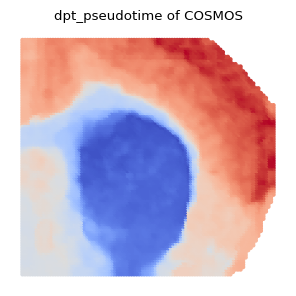

In [16]:

# Calculating pseudo-times 
embedding_adata.uns['iroot'] = np.flatnonzero(adata_new.obs["Cluster_cosmos"] == 'CP2')[0]
sc.tl.diffmap(embedding_adata)
sc.tl.dpt(embedding_adata)
pSM_values_cosmos = embedding_adata.obs['dpt_pseudotime'].to_numpy()


# Ploting figures
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 1, figsize=(3,3))
sz = 10
x = np.array(adata_new.obs['x_pos'])
y = np.array(adata_new.obs['y_pos'])
ax_temp = axes
im = ax_temp.scatter(x, y, s=20, c=pSM_values_cosmos, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('dpt_pseudotime of COSMOS')
plt.tight_layout()
plt.show()

### Showing modality weights of two omics in COSMOS integration

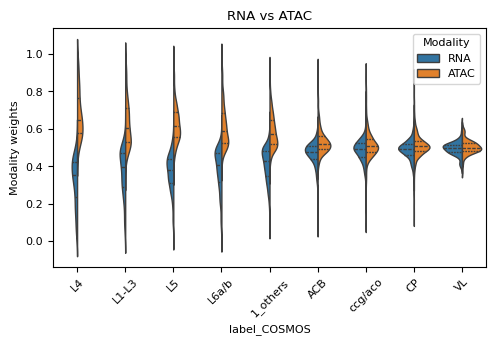

In [17]:
def plot_weight_value(alpha, label, modality1='RNA', modality2='ATAC',order = None):
    df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
    df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
    df['label'] = label
    df = df.set_index('label').stack().reset_index()
    df.columns = ['label_COSMOS', 'Modality', 'Modality weights']
    matplotlib.rcParams['font.size'] = 8.0
    fig, axes = plt.subplots(1, 1, figsize=(5,3))
    ax = sns.violinplot(data=df, x='label_COSMOS', y='Modality weights', hue="Modality",
                split=True, inner="quart", linewidth=1, orient = 'v', order=order)
    plt.tight_layout(w_pad=0.05)
    ax.set_title(modality1 + ' vs ' + modality2)
    ax.set_xticklabels(order, rotation = 45)
ordered_cluster = np.unique(LayerName)
layer_type = ordered_cluster
index_all = [np.array([i for i in range(len(LayerName)) if LayerName[i] == ordered_cluster[0]])]
for k in range(1,len(layer_type)):
    temp_idx = np.array([i for i in range(len(LayerName)) if LayerName[i] == ordered_cluster[k]])
    index_all.append(temp_idx)
    
wghts_mean = np.mean(weights[index_all[0],:],0)
for k in range(1,len(ordered_cluster)):
    wghts_mean_temp = np.mean(weights[index_all[k],:],0)
    wghts_mean = np.vstack([wghts_mean, wghts_mean_temp])
df_wghts_mean = pd.DataFrame(wghts_mean,columns = ['w1','w2'],index = ordered_cluster)

df_sort_mean = df_wghts_mean.sort_values(by=['w1'])
plot_weight_value(weights, np.array(adata_new.obs['LayerName']), order = list(df_sort_mean.index))
plt.show()